In [7]:
import torch.optim as optim

# Define the loss function 
criterion = nn.CrossEntropyLoss()

# set the optimizer as SGD with Momentum 
# Please finish this part
optimizer_SGD = optim.SGD(model_SGD.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Train model_SGD by SGD with Momentum optimization algorith
# Please add code to finish this part.
train_loss_SGD, train_acc_SGD = [], []
test_loss_SGD, test_acc_SGD = [], []

for epoch in range(30):
    train_loss, train_acc = train(trainloader, model_SGD, criterion, optimizer_SGD)
    train_loss_SGD.append(train_loss)
    train_acc_SGD.append(train_acc)
    test_loss, test_acc = test(testloader, model_SGD, criterion)
    test_loss_SGD.append(test_loss)
    test_acc_SGD.append(test_acc)


In [ ]:
# Repeat the training and testing procedure for model_ADAM
# Visualize the results and save the images. Add the images to your assignment solution.
optimizer_ADAM = optim.Adam(model_ADAM.parameters(), lr=0.01)

train_loss_ADAM, train_acc_ADAM = [], []
test_loss_ADAM, test_acc_ADAM = [], []

for epoch in range(30):
    train_loss, train_acc = train(trainloader, model_ADAM, criterion, optimizer_ADAM)
    train_loss_ADAM.append(train_loss)
    train_acc_ADAM.append(train_acc)
    test_loss, test_acc = test(testloader, model_ADAM, criterion)
    test_loss_ADAM.append(test_loss)
    test_acc_ADAM.append(test_acc)

Text(0.5, 1.0, 'Test Accuracy vs Epochs')

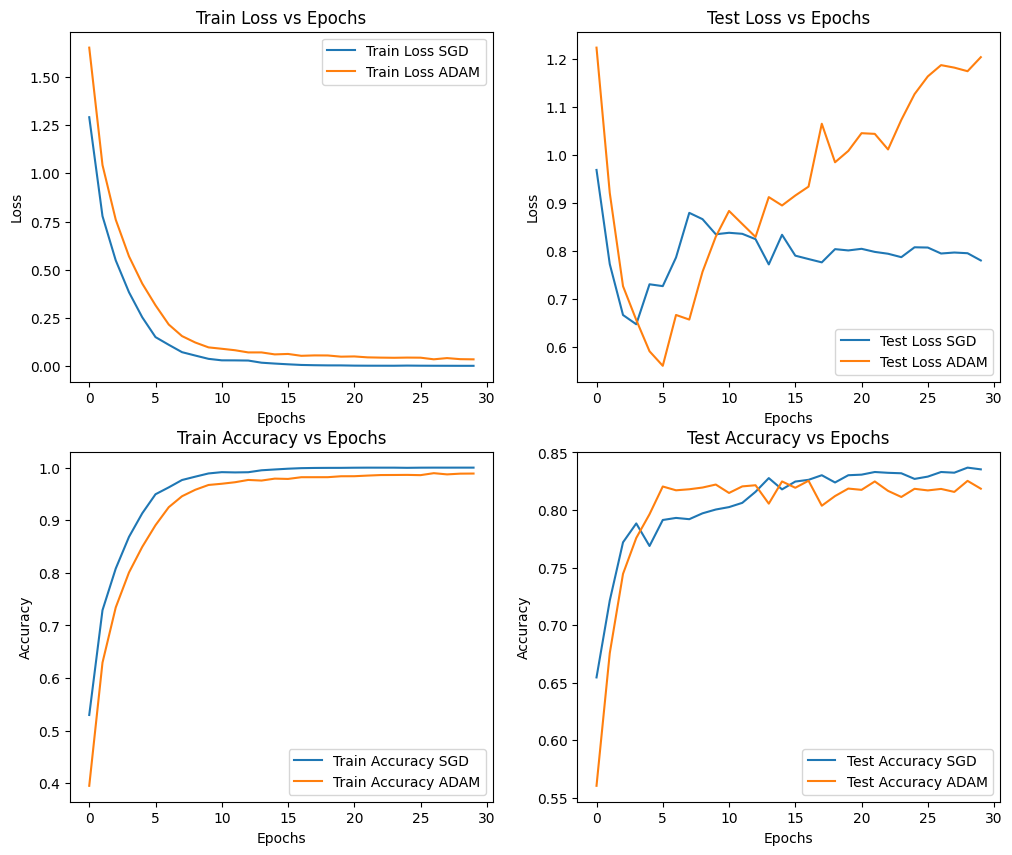

In [12]:
# Visualize the results (You can refer to other tutorial notebooks)
import matplotlib.pyplot as plt

## Add codes to finish this part and save the images. Add the images to your assignment solution.
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(train_loss_SGD, label='Train Loss SGD')
plt.plot(train_loss_ADAM, label='Train Loss ADAM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train Loss vs Epochs')

plt.subplot(2, 2, 2)
plt.plot(test_loss_SGD, label='Test Loss SGD')
plt.plot(test_loss_ADAM, label='Test Loss ADAM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Test Loss vs Epochs')

plt.subplot(2, 2, 3)
plt.plot(train_acc_SGD, label='Train Accuracy SGD')
plt.plot(train_acc_ADAM, label='Train Accuracy ADAM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train Accuracy vs Epochs')

plt.subplot(2, 2, 4)
plt.plot(test_acc_SGD, label='Test Accuracy SGD')
plt.plot(test_acc_ADAM, label='Test Accuracy ADAM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test Accuracy vs Epochs')